# Computer vision pipeline for teff canopy coverage tracking

![](../.assets/imgs/012-canopy-coverage-tracking/phenotyping-pipeline.drawio.png)

This notebook demonstrates the steps of the pipeline used to extract the individual shoots and track the canopy development growth across an image time series.
These steps are highlighted in the diagram above.
A version of the notebook has been published on [Kaggle](https://www.kaggle.com/code/alexandreshinebourne/012-canopy-coverage-tracking-kaggle-version/edit/run/185437387) as the script requires powerful graphics hardware.

To use the script and run the phenotyping on a specific pot:
1. Define the semantic segmentation model you wish to use (cell 2)
1. Load the correct image time series (cell 3)
1. (Advance optional) Adjust the model threshold to make it more sensitive
1. (Advance optional) Change the opening kernel to reduce discontinuities in the prediction (usually not required depending on the model)
1. Run the full pipeline (the PCCr tracking graph is produced in the last cell of the notebook)

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
from PIL import Image
from scipy.ndimage import generate_binary_structure, label
from skimage.morphology import skeletonize

from utils.dl.dataset import IMG_TRANSFORMS_NO_JITTER
from utils.dl.models.mcd_unet import MCDUNet
from utils.image_utils import load_image_ts, reduce_resolution, white_balance
from utils.skeleton_utils import (get_branching_points, get_crossing_points,
                                  get_endpoints)

/home/users/ashine/miniconda3/envs/niab/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [2]:
# Set the model and model weight path here
SEG_MODEL = "mcdunet"  # or "unet" or "deeplab"
MODEL_PATH = "../models_2/20240605150017/best_model.pth"

## Load and pre-process images (reduce resolution)

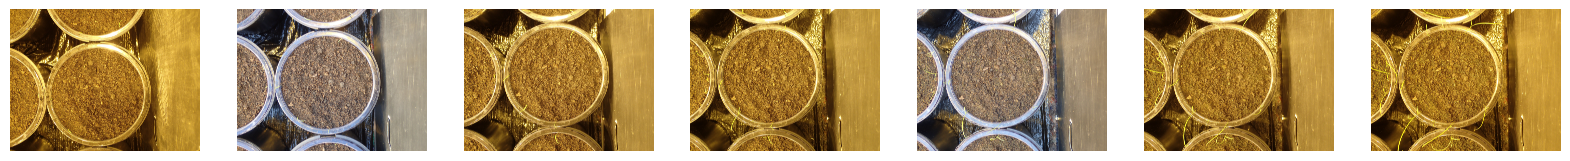

In [3]:
# Load image time series and display
raw_images = load_image_ts(
    dataset_root="../datasets/niab",
    exp=1,
    block=1,  # change to the different block numbers (note that block 2 has some missing images)
    pot=10,  # change to the different pot numbers
)

fig, ax = plt.subplots(1, len(raw_images), figsize=(20, 20))
for i, image in enumerate(raw_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis("off")

In [4]:
# Reduce resolution of images to 10% of the original size to speed up
# processing (notably segmentation and circle detection)
small_images = [reduce_resolution(image, 10) for image in raw_images]

print("Original image size: ", raw_images[0].shape)
print("Reduced image size: ", small_images[0].shape)

Original image size:  (3456, 4608, 3)
Reduced image size:  (345, 460, 3)


## DL semantic shoot segmentation

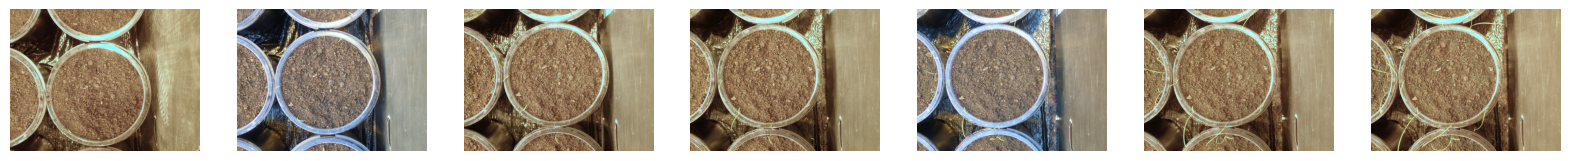

In [5]:
# White balance images to make them more similar across the time series and
# display
wb_small_images = [white_balance(image) for image in small_images]

fig, ax = plt.subplots(1, len(wb_small_images), figsize=(20, 20))
for i, image in enumerate(wb_small_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis("off")

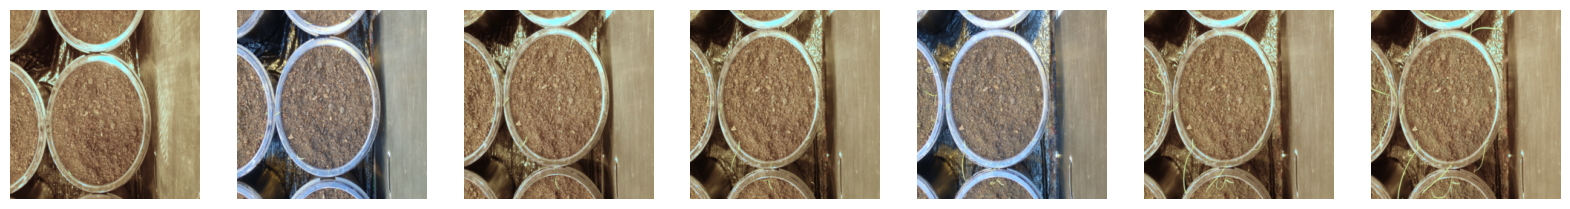

In [6]:
# Transform images for input to the shoot segmentation model
transformed_wb_small_images = [
    IMG_TRANSFORMS_NO_JITTER(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
    for image in wb_small_images
]

# Display the transformed images
fig, ax = plt.subplots(1, len(transformed_wb_small_images), figsize=(20, 20))
for i, image in enumerate(transformed_wb_small_images):
    ax[i].imshow(image.permute(1, 2, 0))
    ax[i].axis("off")

Running model using cuda device


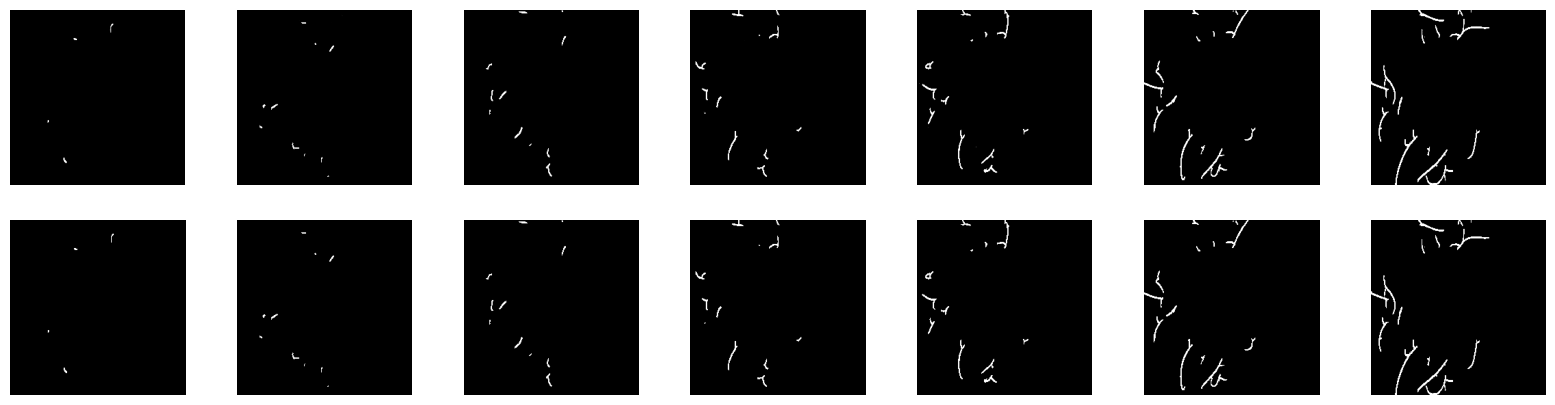

In [7]:
THRESHOLD = 0.5  # Threshold for binary predictions

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Running model using {device} device")

# Create an instance of the model and move it to the device (GPU or CPU)
if SEG_MODEL == "unet":
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation="sigmoid",
    ).to(device)
elif SEG_MODEL == "deeplab":
    model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        activation="sigmoid",
    ).to(device)
elif SEG_MODEL == "mcdunet":
    model = MCDUNet(
        n_channels=3,
        n_classes=1,
        bilinear=True,
        ddims=[32, 64, 128, 256, 512],
        UQ=True,
        activation=True,
    ).to(device)
else:
    raise ValueError("Invalid segmentation model")

model.load_state_dict(torch.load(MODEL_PATH))
model.eval()  # Set model to evaluation mode i.e. doesn't change weights

# Inference on the transformed images
predictions = [
    model(image.unsqueeze(0).to(device)) for image in transformed_wb_small_images
]

# Generate binary predictions from the model output
binary_predictions = [
    prediction.squeeze(0).squeeze(0) > THRESHOLD for prediction in predictions
]

# Display predictions and binary predictions
fig, ax = plt.subplots(2, len(predictions), figsize=(20, 5))
for i, (prediction, binary_prediction) in enumerate(
    zip(predictions, binary_predictions)
):
    ax[0, i].imshow(
        prediction.squeeze(0).squeeze(0).cpu().detach().numpy(), cmap="gray"
    )
    ax[0, i].axis("off")
    ax[1, i].imshow(binary_prediction.cpu().detach().numpy(), cmap="gray")
    ax[1, i].axis("off")

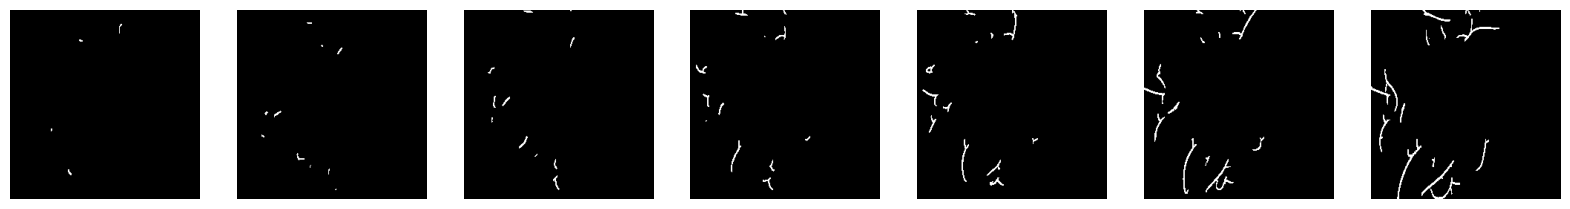

In [8]:
# Increase continuity of the binary predictions by opening (an erosion
# operation followed by a dilation operation)
kernel = np.ones((1, 1), np.uint8)  # 1x1 kernel does nothing
opened_resized_predictions = [
    cv2.morphologyEx(prediction.cpu().numpy().astype(np.uint8), cv2.MORPH_OPEN, kernel)
    for prediction in binary_predictions
]

fig, ax = plt.subplots(1, len(small_images), figsize=(20, 5))
for i, image in enumerate(small_images):
    ax[i].imshow(opened_resized_predictions[i], cmap="gray")
    ax[i].axis("off")

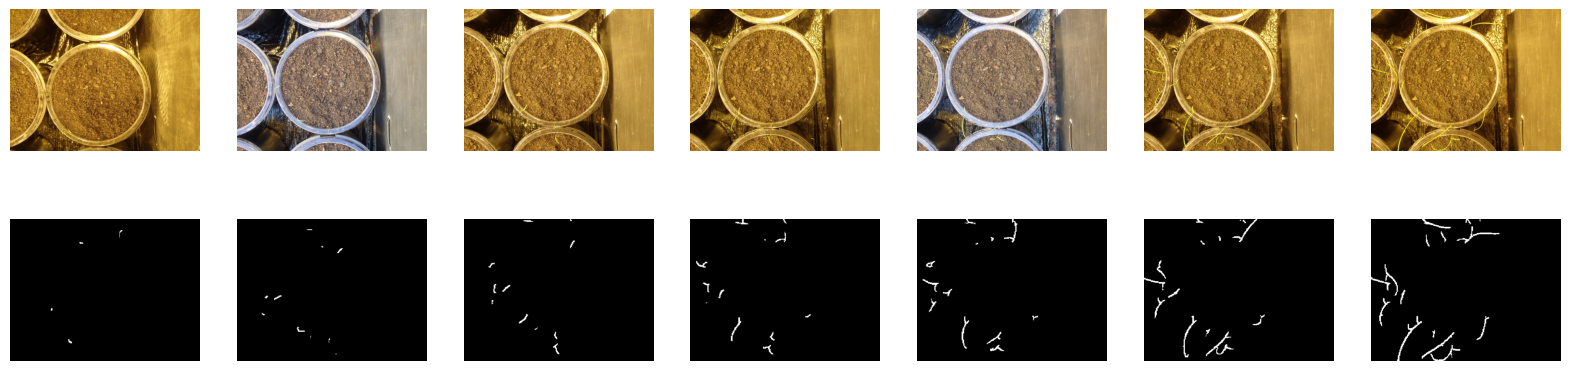

In [9]:
# Resize the predictions so that they match with the initial images
resized_predictions = [
    cv2.resize(
        prediction,
        (small_images[0].shape[1], small_images[0].shape[0]),
        interpolation=cv2.INTER_NEAREST,
    )
    for prediction in opened_resized_predictions
]

# Plot the images and the predictions
fig, ax = plt.subplots(2, len(small_images), figsize=(20, 5))
for i, image in enumerate(small_images):
    ax[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0, i].axis("off")
    ax[1, i].imshow(resized_predictions[i], cmap="gray")
    ax[1, i].axis("off")

## Identifying pot rims

[((214, 206), 128), ((218, 176), 128), ((224, 160), 127), ((190, 164), 126), ((190, 164), 129), ((194, 158), 126), ((194, 160), 122)]


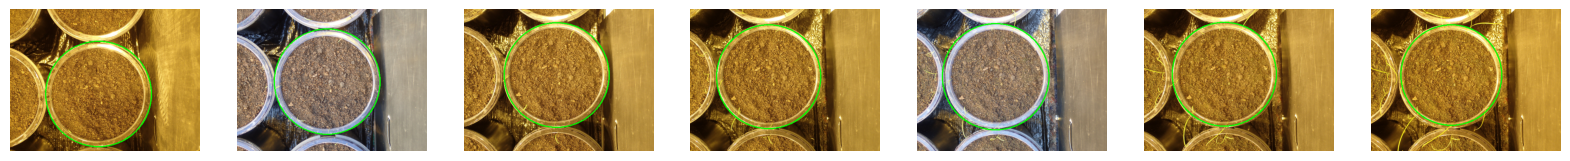

In [10]:
# Convert the images to greyscale for circle detection
grey_small_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in small_images]

saved_circles = []  # [((x, y), r)...]

# Detect circles in each greyscale image
for i, img in enumerate(grey_small_images):
    # Use HoughCircles to detect circles in the image
    # Parameters have been tuned to detect the pot rim in the images
    # (might need to be adjusted for other images)
    circles = cv2.HoughCircles(
        img,
        cv2.HOUGH_GRADIENT,
        1,
        100,
        param1=50,
        param2=30,
        minRadius=120,
        maxRadius=135,
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            saved_circles.append((center, radius))
            cv2.circle(small_images[i], center, radius, (0, 255, 0), 2)
            break  # Only consider the first circle detected

print(saved_circles)

fig, ax = plt.subplots(1, len(small_images), figsize=(20, 20))
for i, image in enumerate(small_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis("off")

## Identify shoots belonging to pot

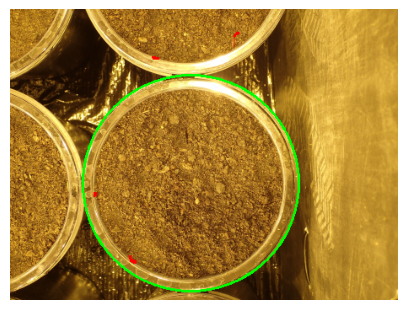

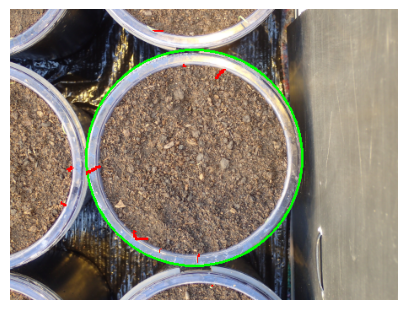

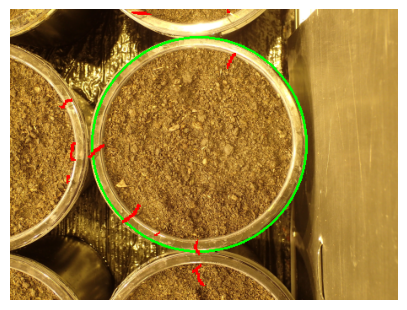

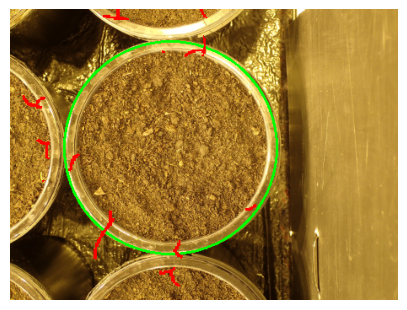

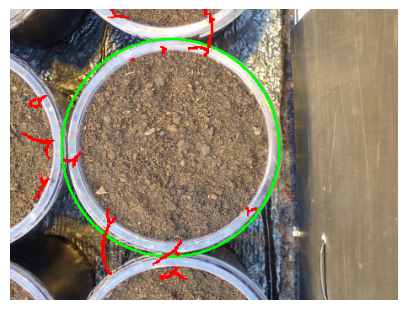

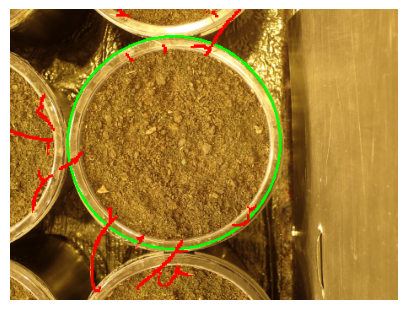

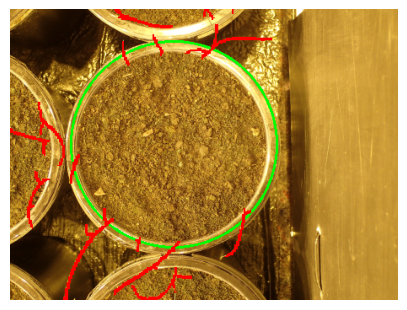

In [11]:
# Overlay the circle on the predictions
for i, (img, prediction) in enumerate(zip(small_images, resized_predictions)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img[prediction == 1] = [255, 0, 0]

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img)
    ax.axis("off")

    plt.show()

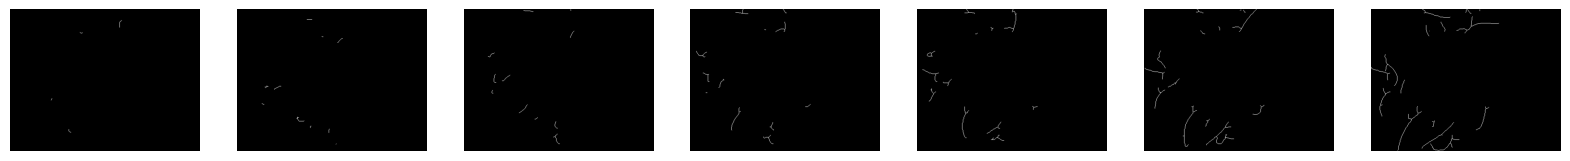

In [12]:
# Skeletonize the binary predictions masks to run logic on the geometry of the
# shoots and the pot rim
skeletonised_masks = [skeletonize(prediction) for prediction in resized_predictions]

# plot the skeletonised mask
fig, ax = plt.subplots(1, len(skeletonised_masks), figsize=(20, 20))
for i, skeleton in enumerate(skeletonised_masks):
    ax[i].imshow(skeleton, cmap="gray")
    ax[i].axis("off")

Number of labels: 4
Number of labels post filtering: 2
Number of labels: 10
Number of labels post filtering: 6
Number of labels: 11
Number of labels post filtering: 5
Number of labels: 12
Number of labels post filtering: 6
Number of labels: 12
Number of labels post filtering: 7
Number of labels: 14
Number of labels post filtering: 8
Number of labels: 16
Number of labels post filtering: 8


[]

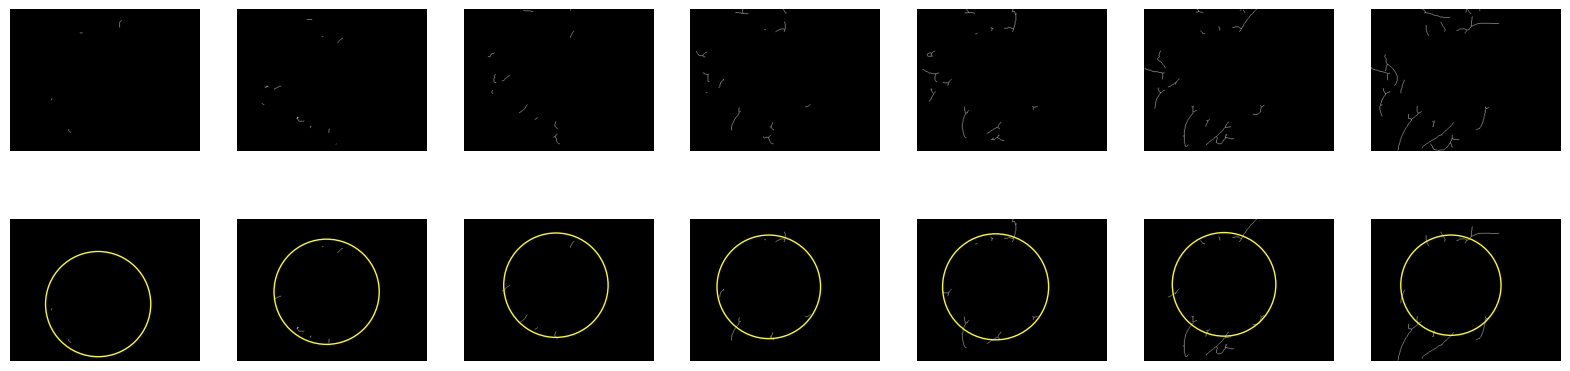

In [13]:
# Initial filtering: removing shoots that do not have any endpoints within the
# pot rim i.e. that are not from that pot

# Array of filtered masks
filtered_masks = []

# Create a structuring element for 8-connectivity
s = generate_binary_structure(2, 2)

for skeletonised_mask_nb in range(len(skeletonised_masks)):

    # Get the coordinates of the circle for the current image
    circle_coords = saved_circles[skeletonised_mask_nb]  # ((x, y), r)

    # Label function separates each skeleton in the skeletonised mask based on
    # connectivity. Uses 4-connectivity by default, so we use a structuring
    # element to specify 8-connectivity.
    labeled_skeletons, num_labels = label(
        skeletonised_masks[skeletonised_mask_nb], structure=s
    )

    print(f"Number of labels: {num_labels}")

    # New image of the same shape as original
    new_image = np.zeros_like(skeletonised_masks[skeletonised_mask_nb]).astype(np.uint8)

    # For each individual skeleton (continuous shape) in the image
    for skeleton in range(1, num_labels + 1):

        # Highlight the particular skeleton
        highlighted = np.where(labeled_skeletons == skeleton, 1, 0)

        # Get skeleton endpoints
        end_points = get_endpoints(highlighted)

        # If at least 1 endpoint is within the circle, assume that the shoot is
        # part of the pot
        is_in_circle = False
        for point in end_points:
            in_circle = (
                (point[0] - circle_coords[0][1]) ** 2
                + (point[1] - circle_coords[0][0]) ** 2
            ) <= circle_coords[1] ** 2
            if in_circle:
                is_in_circle = True
                break

        # If the skeleton meets the condition (is_in_circle), add it to the
        # skeletons to form the newly filtered image
        if is_in_circle:
            new_image += highlighted.astype(np.uint8)

    # Nb of labels post filtering
    labeled_skeletons, num_labels = label(new_image, structure=s)
    print(f"Number of labels post filtering: {num_labels}")

    # Save the new image post-filtering
    filtered_masks.append(new_image)


fig, ax = plt.subplots(2, len(filtered_masks), figsize=(20, 5))
for i, filtered_mask in enumerate(filtered_masks):
    # Pre-filtered mask
    ax[0, i].imshow(skeletonised_masks[i], cmap="gray")
    ax[0, i].axis("off")

    # Post-filtered mask
    ax[1, i].imshow(filtered_mask, cmap="gray")
    ax[1, i].axis("off")

    # Display the circle
    circle_coords = saved_circles[i]
    circle = plt.Circle(circle_coords[0], circle_coords[1], color="yellow", fill=False)

    ax[1, i].add_artist(circle)


plt.plot()

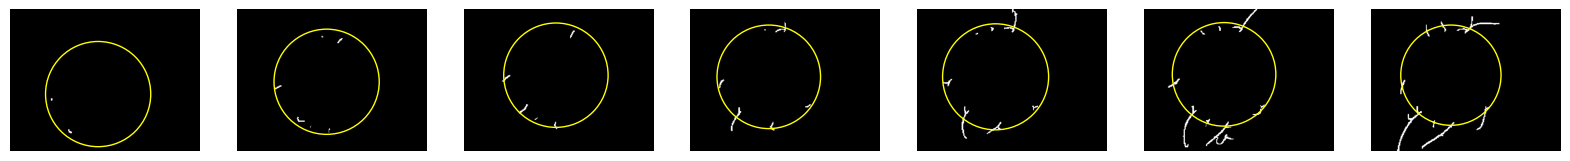

In [14]:
# Overlay predicted masks with filtered skeletonised masks

updated_masks = []

for original, skeleton in zip(resized_predictions, filtered_masks):
    # Perform an "and" operation (logical and)
    labeled_original, num_labels_og = label(original, structure=s)
    labeled_skeleton, num_labels = label(skeleton, structure=s)

    new_image = np.zeros_like(original).astype(np.uint8)

    for skeleton in range(1, num_labels + 1):
        # get the highlighted area
        highlighted = np.where(labeled_skeleton == skeleton, 1, 0)

        # get the label of the original image that corresponds to the shape in the skeleton i.e. find the shoot in the original image that corresponds to its skeleton
        # i.e find the label in the original image that has the most overlap with the skeleton
        max_overlap = 0
        best_label = 0
        for og in range(1, num_labels_og + 1):
            overlap = np.sum(
                np.logical_and(np.where(labeled_original == og, 1, 0), highlighted)
            )
            if overlap > max_overlap:
                max_overlap = overlap
                best_label = og

        new_image += np.where(labeled_original == best_label, 1, 0).astype(np.uint8)

    updated_masks.append(new_image)


fig, ax = plt.subplots(1, len(updated_masks), figsize=(20, 20))
for i, updated_mask in enumerate(updated_masks):
    ax[i].imshow(updated_mask, cmap="gray")
    ax[i].axis("off")

    circle_coords = saved_circles[i]
    circle = plt.Circle(circle_coords[0], circle_coords[1], color="yellow", fill=False)
    ax[i].add_artist(circle)

## Identifying individual within pot

Processing image 0
Number of labels: 2
End points: [[217 101]
 [221  99]]
Angle: 172.56859202882748, Sector: 7
End points: [[292 142]
 [299 147]]
Angle: 125.7701137562723, Sector: 5
Processing image 1
Number of labels: 6
End points: [[ 66 205]
 [ 67 208]]
Angle: 263.259943902053, Sector: 11
End points: [[ 71 255]
 [ 81 243]]
Angle: 289.4114868586836, Sector: 12
End points: [[187 106]
 [195  90]]
Angle: 174.39072555355418, Sector: 7
End points: [[263 149]
 [265 144]
 [271 162]]
Angle: 129.7421908310453, Sector: 5
End points: [[284 179]
 [288 177]]
Angle: 110.10623479835934, Sector: 4
End points: [[291 223]
 [300 222]]
Angle: 88.15238973400541, Sector: 3
Processing image 2
Number of labels: 5
End points: [[ 53 266]
 [ 69 257]]
Angle: 291.43116727623317, Sector: 12
End points: [[160 111]
 [174  92]]
Angle: 180.0, Sector: 8
End points: [[232 153]
 [252 133]]
Angle: 134.59933674420785, Sector: 5
End points: [[263 177]
 [267 171]]
Angle: 116.35046124594861, Sector: 5
End points: [[273 222]
 

[]

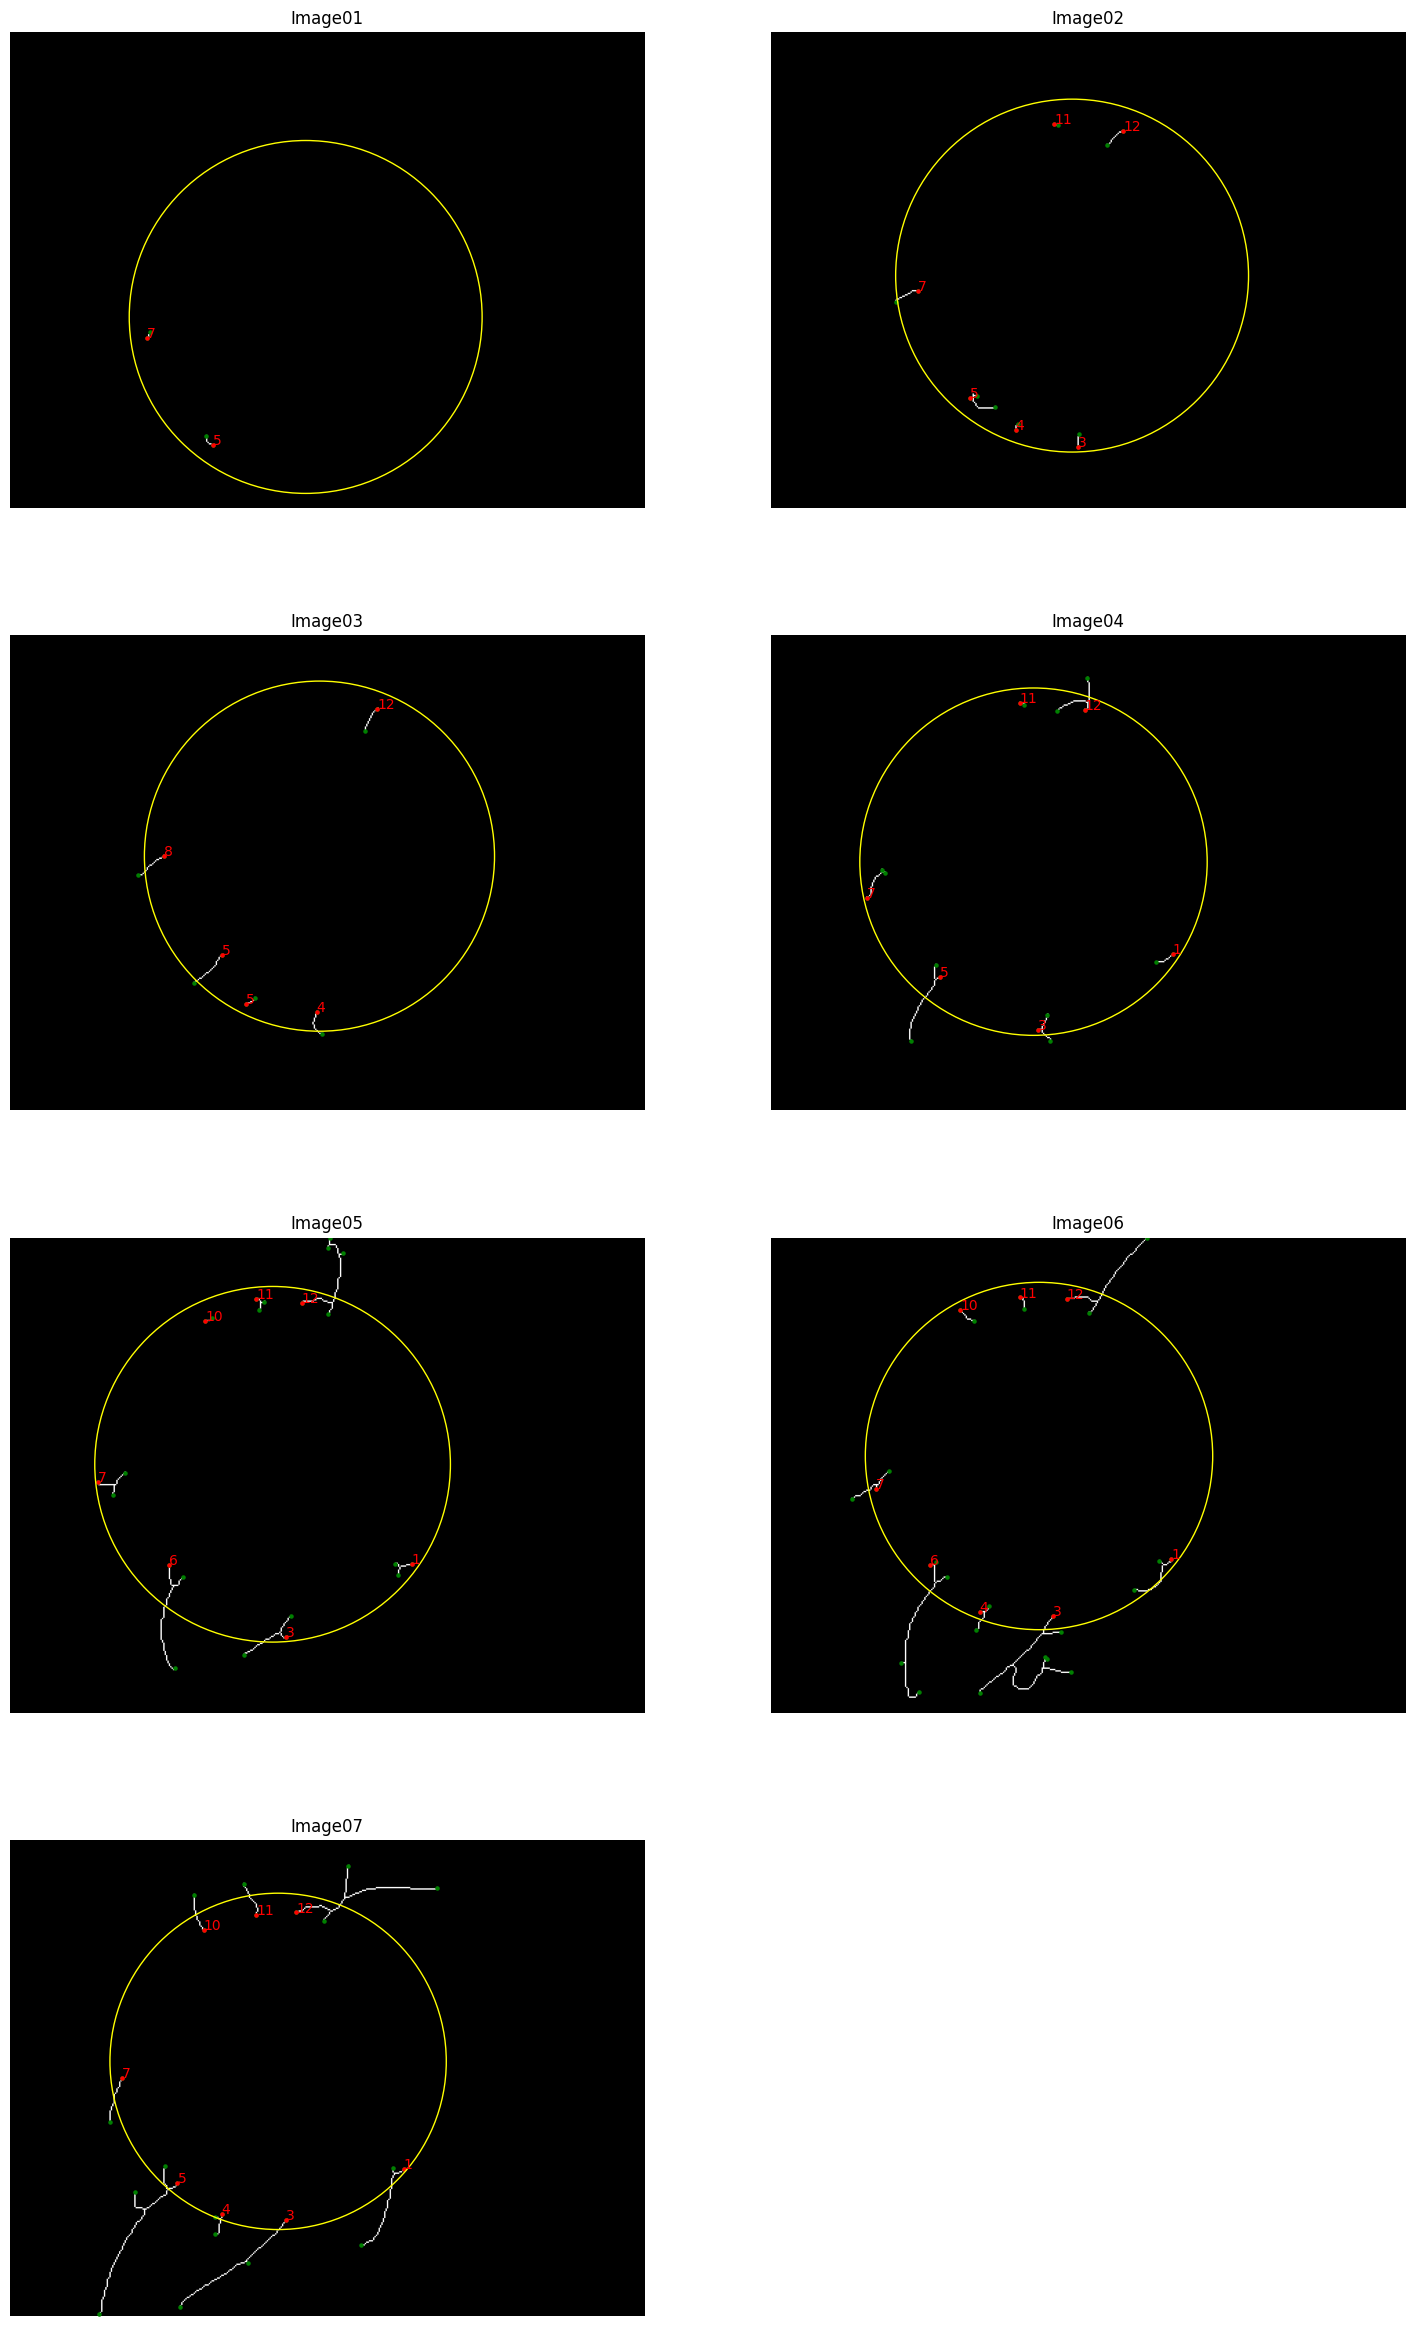

In [15]:
# For each img in the time series, break down the circle into 16 sectors and
# determine which shoot is in which sector


def get_sectors(endpoints: list, circle_coords: tuple, nb_sectors: int, ax) -> int:
    """
    Determine the segment of the circle that the shoot is from
    """

    # Get the circle
    (x, y), r = circle_coords

    # Remove any endpoints outside of the circle
    endpoints = [
        point
        for point in endpoints
        if np.sqrt((point[1] - x) ** 2 + (point[0] - y) ** 2) <= r
    ]

    # There are edge cases where they may be endpoints in several sectors the
    # shoot tip and the shoot base, we assume that the shoot base is the one
    # that is closest to the rim of the pot so order the endpoints by distance
    # to the rim of the pot
    endpoints = sorted(
        endpoints,
        key=lambda point: np.sqrt((point[1] - x) ** 2 + (point[0] - y) ** 2),
        reverse=True,
    )

    # plot the endpoints[0] in green
    ax.scatter(endpoints[0][1], endpoints[0][0], c="red", s=5)

    # determine sector of the circle that the shoot is in based in the endpoints[0]
    # Calculate the angle of the shoot tip
    angle = np.arctan2(endpoints[0][0] - y, endpoints[0][1] - x) * 180 / np.pi

    # Make sure the angle is positive
    if angle < 0:
        angle += 360

    # Calculate the sector
    sector = int(angle / (360 / nb_sectors))

    # annotate endpoint with the sector number
    ax.annotate(sector, (endpoints[0][1], endpoints[0][0]), color="red")

    print(f"Angle: {angle}, Sector: {sector}")

    return sector


tracking_total_length = np.zeros((len(filtered_masks), 16))
tracking_area_sector_ratio = np.zeros((len(filtered_masks), 16))

fig, ax = plt.subplots(4, 2, figsize=(18, 30))

for i, filtered_mask in enumerate(filtered_masks):
    # ax index
    row = i // 2
    col = i % 2

    print(f"Processing image {i}")
    (x, y), r = saved_circles[i]

    sector_area = np.pi * r**2 / 16

    labeled_skeletons, num_labels = label(filtered_masks[i], structure=s)
    labeled_original_post_filter, _ = label(updated_masks[i], structure=s)

    print(f"Number of labels: {num_labels}")

    for skeleton in range(1, num_labels + 1):
        highlighted = np.where(labeled_skeletons == skeleton, 1, 0)

        highlited_or = np.where(labeled_original_post_filter == skeleton, 1, 0)

        end_points = get_endpoints(highlighted)  # Careful they are returned as [[y, x]]
        print(f"End points: {end_points}")

        # plot the endpoints in green
        for point in end_points:
            ax[row, col].scatter(point[1], point[0], c="green", s=5)

        if len(end_points) != 0:
            sector = get_sectors(end_points, saved_circles[i], 16, ax[row, col])
            # In theory if there is a one to one relationship between the shoot
            # and the sector this would be a = not a += but due to limitation
            # of instance segmentation currently this is set to +=
            tracking_total_length[i, sector] += np.sum(highlighted)
            tracking_area_sector_ratio[i, sector] += np.sum(highlited_or) / sector_area

        else:
            print("No endpoints found")

    # Display the circle
    circle = plt.Circle((x, y), r, color="yellow", fill=False)
    ax[row, col].add_artist(circle)

    # display the filtered mask
    ax[row, col].imshow(filtered_mask, cmap="gray")
    ax[row, col].axis("off")

    # add title for the image number
    ax[row, col].set_title(f"Image0{i+1}")

# remove the empty plots
ax[3, 1].axis("off")

plt.plot()

## Plot canopy coverage ratio

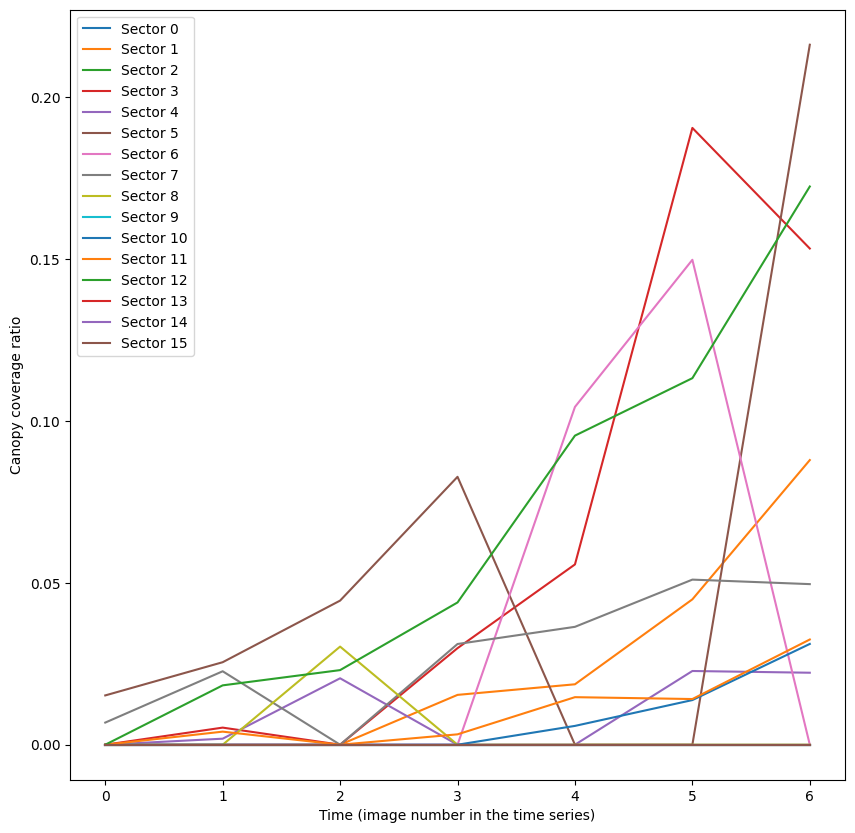

In [16]:
# Plot the PCCr over time
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(16):
    ax.plot(
        range(len(filtered_masks)),
        tracking_area_sector_ratio[
            :, i
        ],  # using area from original mask (not skeletonised)
        label=f"Sector {i}",
    )

plt.xlabel("Time (image number in the time series)")
plt.ylabel("Plant Canopy Coverage ratio (PCCr)")

plt.legend()